# INF8775 – Analyse et conception d’algorithmes
# TP3 – Automne 2024

NOM, Prénom, 1234567

NOM, Prénom, 1234567

Note finale:

<u>**Date limite de remise :**</u>  4 décembre 23h59 pour les deux groupes

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte.

- Vous pouvez utiliser des fichiers externes pour stocker des exemplaires et des résultats, mais nous devons être capable de comprendre facilement votre démarche et de la reproduire.

- <u>**IMPORTANT**</u> Remettez le fichier du notebook sur Moodle avec le nom `MATRICULE1_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et est une occasion de mettre en application les connaissances vues en cours. Vous devrez développer l'algorithme de votre choix pour essayer de résoudre le plus efficacement possible le problème donné. Une partie de la note sera accordée en fonction des résultats que vous obtiendrez par rapport aux autres équipes.

## Description du problème

Le problème qu'on vous demande de résoudre cette fois-ci est un peu plus difficile. Vous êtes responsable de la séparation des voteurs d'un pays en circonscriptions. Un des deux candidats principaux, M. T, vient vous voir et vous demande de lui garantir une victoire (pour un montant non négligeable d'argent). Évidemment, vous refusez, mais le problème est intéressant et vous décidez d'essayez de le résoudre. Si ça vous intéresse, ce problème est ce qu'on appelle du *gerrymandering*.

Vous aurez comme entrée à votre problème une carte du pays (représentée par une matrice carrée $n \times n$) qui contient à chaque position le nombre de voteurs pour candidat X (un chiffre entre 0 et 1000). Votre objectif est de créer $n$ circonscriptions de sorte à ce que candidat X gagne l'élection. Quelques spécifications importantes:

- La variable $n$ représente un côté de la matrice. Il y a donc, $n^2$ villes.
- Chaque position de la matrice représente une ville
- Chaque circonscription doit contenir **$n$ villes**. Une solution reste valide si une circonscription ne contient pas exactement $n$ villes, mais il y a une **pénalité** qui y est associée.
- Les villes d'une circonscription doivent être proche les unes des autres. On aimerait garder cette **distance à, au plus, $n/2$**. Encore une fois, on permet de briser cette contrainte, mais il y aura une pénalité qui y est associée. (**Distance manhattan**)
- Les villes d'une circonscription ne doivent **pas être nécessairement voisines** tant qu'on respecte la distance maximale. Voir l'exemple plus bas.
- Le candidat remporte une circonscription si le nombre de voteurs dans cette circonscription est supérieur à $500n$.
- Le candidat cherche à remporter le plus de circonscriptions qu'il peut.

![alt text](distance_example.png)


## Jeu de données

La classe Problem existe pour simplifier l'interface des différentes fonctions utilitaires. Elle permet de générer des jeux de données avec la méthode `generate_sample` ci-dessous. Elle génère une matrice carrée de taille $n$ contenant des nombres entre $1$ et $1000$. Vous pouvez utilisez des exemplaires aléatoires pour tester votre code. La compétition sera faite sur les mêmes exemplaires de tailles différentes pour toutes les équipes d'un même groupe.

In [4]:
import random
from collections.abc import Iterable

def generate_city() -> int:
    return round(min(1000,max(0,random.normalvariate(450,200))))

class Problem():
    def __init__(self, size: int, num_samples: int = 5) -> None:
        self.size = size
        self.num_samples = num_samples

    def generate_sample(self) -> list[list[int]]:
        """Returns a matrix containing values between 0 and 1000. Each value is the number of voters in a given city"""
        return [[generate_city() for _ in range(self.size)] for _ in range(self.size)]

    def generate_dataset(self) -> Iterable[list[list[int]]]:
        """Returns an iterator over as many samples as are described"""
        return (self.generate_sample() for _ in range(self.num_samples))

### Création des différent exemplaires pour tester.

In [5]:
size = 5
num_samples = 3
problem = Problem(size, num_samples)

# Générer un échantillon unique
sample = problem.generate_sample()
print("Exemple d'une matrice de votes (taille 5x5) :")
for row in sample:
    print(row)

# Générer un dataset complet
dataset = problem.generate_dataset()
print("\nDataset complet :")
for i, matrix in enumerate(dataset, 1):
    print(f"Exemple {i}:")
    for row in matrix:
        print(row)
    print()


Exemple d'une matrice de votes (taille 5x5) :
[290, 458, 252, 291, 100]
[350, 531, 617, 501, 576]
[709, 559, 413, 505, 379]
[132, 233, 769, 635, 568]
[330, 186, 589, 336, 24]

Dataset complet :
Exemple 1:
[476, 97, 651, 189, 712]
[836, 663, 233, 751, 728]
[177, 360, 517, 663, 414]
[856, 315, 564, 257, 560]
[412, 168, 427, 786, 255]

Exemple 2:
[518, 283, 281, 341, 547]
[477, 112, 83, 473, 211]
[454, 470, 335, 361, 104]
[393, 468, 373, 267, 414]
[650, 488, 214, 539, 373]

Exemple 3:
[555, 696, 814, 240, 572]
[571, 434, 93, 398, 721]
[281, 579, 375, 372, 411]
[0, 437, 0, 435, 653]
[264, 322, 421, 75, 446]



# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [6]:
import matplotlib.pyplot as plt
import time
from collections.abc import Callable
from math import ceil
from scipy.stats import linregress

class InvalidSolution(Exception):
    def __init__(self):
        super().__init__("Invalid solution, verify your code.")

class Measure():
    """A wrapper to contain information on taken measures"""
    def __init__(self, size: int, mean: int, score:int) -> None:
        self.size = size
        self.mean_score = score
        self.mean = mean

def score_solution(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> int:
    """Returns the score of the current solution. The score function is a penalty that must be minimized."""
    return votes_score(original, solution) + size_score(solution) + distance_score(solution)

def votes_score(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to lost districts. 
    It is 5 times the square of the number of lost districts."""
    lost_districts = 0
    for district in solution:
        sum = 0
        for city in district:
            sum += original[city[0]][city[1]]
        if sum <= 500*len(district):
            lost_districts += 1
    return 5 * lost_districts**2

def size_score(solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to districts having the wrong size.
    It is the square of the difference between the wanted number of cities and the 
    current number of cities in a given district."""
    n = len(solution)
    size_penality = 0
    for district in solution:
        size_penality += (len(district)-n)**2
    return size_penality

def distance_score(solution: list[list[tuple[int,int]]]) -> int:
    """Calculates the part of the score associated to the distance between cities in a district.
    It is the mean square distance between each city and every other city in its district."""
    distance_score = 0
    n = len(solution)
    for district in solution:
        for i,city in enumerate(district):
            for j in range(i+1, len(district)):
                distance_score += (max(0, distance_manhattan(city, district[j])-ceil(n/2)))**2
    return distance_score/len(solution)

def distance_manhattan(city_a: tuple[int,int], city_b: tuple[int,int]) -> int:
    return abs(city_a[0] - city_b[0]) + abs(city_a[1] - city_b[1])

def is_valid_solution(original: list[list[int]], solution: list[list[tuple[int,int]]]) -> bool:
    """Validates solution"""
    n = len(original)

    if len(solution) != n:
        print(f"The solution does not contain {n} districts.")
        return False

    for district in solution:
        if len(district) < 1:
            print("The solution contains empty districts.")
            return False
        for city in district:
            if len(city)!=2:
                print("Solution must contain 2 coordinates per city.")
                return False
        for coord in city:
            if coord < 0 or coord >=n:
                print(f"City coordinates must below {n} and positive.")
                return False

    coord_set = set()
    for district in solution:
        for city in district:
            coord_set.add(city)
    if len(coord_set) != n*n:
        print(f"Solution contained {len(coord_set)} different cities while there should be {n*n} cities in the solution.")
        return False

    # Solution is valid
    return True

def make_problems(sizes: list[int], num_samples: int = 5) -> list[Problem]:
    """Creates problem instances using given sizes and max_numbers"""
    return [Problem(size,num_samples) for size in sizes]

def measure(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], sample: list[list[int]], time_scale: int = 1000) -> tuple[int,int]:
    """Returns a tuple containing the time as well as the score of the solution, in that order.
    
    Parameters:
        time_scale: Controls the level of precision of the time measurements.

    Raises:
        InvalidSolution: If the procedure returns an invalid solution, raises an exception.
    """
    start: int = time.time() * time_scale
    solution: list[int] = procedure(sample)
    end: int = time.time() * time_scale
    if not is_valid_solution(sample, solution):
        raise InvalidSolution()
    return (round(end - start), score_solution(sample, solution))

def measure_mean(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], prob: Problem, time_scale: int = 1000) -> Measure:
    """Generates multiple samples with the specified parameters and returns a Measure 
    instance representing the result as well as the problem.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    """
    results = [measure(procedure,sample,time_scale) for sample in prob.generate_dataset()]
    mean_time = sum(result[0] for result in results) / prob.num_samples
    mean_score = sum(result[1] for result in results) / prob.num_samples
    return Measure(prob.size, mean_time, mean_score)

def measure_range(procedure: Callable[[list[list[int]]],list[list[tuple[int,int]]]], problems: list[Problem], time_scale: int = 1000) -> list[Measure]:
    """Measures the mean time taken for each problem in the given list.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.

    Returns:
        A list of Measure instances containing the specifications
        of the problem as well as the mean time and the score.
    """
    return [
        measure_mean(procedure, prob, time_scale)
        for prob in problems
    ]

def display_data_as_table(measures: list[Measure]):
    """Prints a table with the data in the given list of measures"""
    print("{: <12} {: <12} {: <12}".format("Taille", "Temps moyen", "Score moyen"))
    for measure in measures:
        print("{: <12} {: <12} {: <12}".format(measure.size, measure.mean, measure.mean_score))

### The different tests are below, the names are in french to avoid confusion

def test_de_puissance(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de puissance"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    # Log both sets of values
    x = list(data.keys())
    y = list(data.values())

    # Perform the lin regression
    m, b, rvalue, _, _ = linregress(x, y)

    # Estimate the values of y based on the lin regression results
    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def test_de_rapport(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de rapport"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

def test_de_constantes(
    data: dict[int,int],
    x_label: str,
    y_label: str = "Temps (ms)",
    title: str = "Test de constantes"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

# Algorithme

Votre algorithme sera en partie noté en fonction d'une évaluation relative entre les équipes. 4 points seront donnés aux équipes qui se classeront dans le premier quartile lors de notre évaluation sur un ensemble d'exemplaires. Les équipes se trouvant dans le quartile dont les algorithmes ont le moins bien performé recevront 1 point.

**IMPORTANT** Votre algo doit retourner une solution après 3 minutes. Si ce n'est pas le cas, vous serez pénalisé.

In [13]:
def solve_problem(matrix: list[list[int]]) -> list[list[tuple[int, int]]]:
    n = len(matrix) # Un côté de la matrice
    cities = [(i, j) for i in range(n) for j in range(n)] # Tout les positions dans la matrice
    districts = [] # Résultat
    assigned = set()

    while len(districts) < n: # Pour tout les circonscriptions
        district = []
        while len(district) < n: # Pour la circonscription actuelle
            unassigned_cities = [city for city in cities if city not in assigned]
            if not unassigned_cities: # Aucune ville non assignée
                break

            candidate = max(unassigned_cities, key=lambda city: matrix[city[0]][city[1]])
            district.append(candidate)
            assigned.add(candidate)

        districts.append(district)

    for district in districts:
        while len(district) > n:
            excess_city = min(district, key=lambda city: matrix[city[0]][city[1]])
            district.remove(excess_city)
            assigned.remove(excess_city)

    return districts


In [ ]:
size = 4
num_samples = 3 
problem = Problem(size, num_samples)
print("Exemple d'une matrice de votes (taille 5x5) :")
for row in sample:
    print(row)

sample = problem.generate_sample()
print(solve_problem(sample)) 


[[(2, 1), (0, 2), (3, 3), (1, 0)], [(2, 0), (0, 0), (2, 2), (3, 0)], [(1, 3), (0, 1), (3, 1), (3, 2)], [(1, 2), (1, 1), (2, 3), (0, 3)]]


### Pour visualiser

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_districts(matrix, districts):
    """Visualizes the districts on a grid."""
    n = len(matrix)  # Size of the matrix
    grid = np.zeros((n, n), dtype=int)
    for district_id, district in enumerate(districts, start=1):
        for x, y in district:
            grid[x, y] = district_id
    plt.figure(figsize=(8, 8))
    plt.imshow(grid, cmap="tab20", interpolation="nearest")
    plt.colorbar(label="District ID")
    for i in range(n):
        for j in range(n):
            plt.text(j, i, f"{matrix[i][j]}", ha="center", va="center", color="white", fontsize=8)

    plt.title("Visualization of Districts")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.xticks(range(n))
    plt.yticks(range(n))
    plt.grid(True, color="black", linewidth=0.5)
    plt.show()


Solution: [[(2, 1), (0, 2), (3, 3), (1, 0)], [(2, 0), (0, 0), (2, 2), (3, 0)], [(1, 3), (0, 1), (3, 1), (3, 2)], [(1, 2), (1, 1), (2, 3), (0, 3)]]


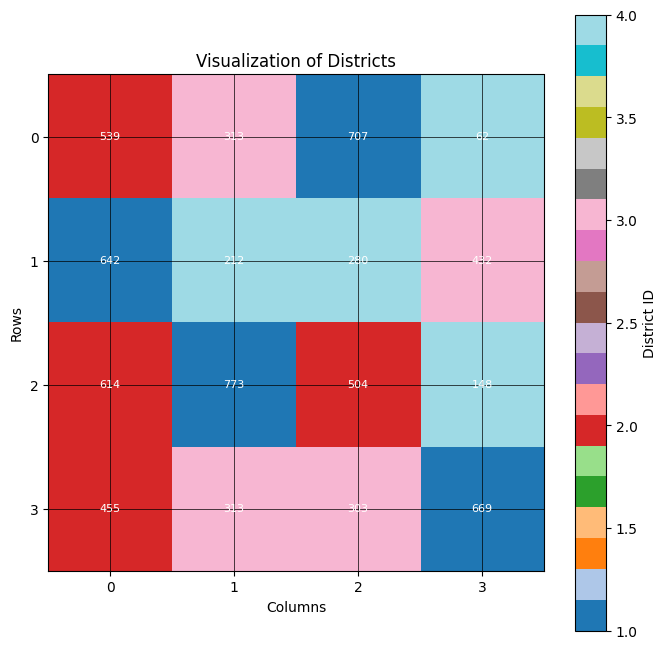

In [21]:
results = solve_problem(sample)
print("Solution:", results)
visualize_districts(sample, results)

# Analyse asymptotique

Effectuer une analyse asymptotique de votre algorithme.

# Analyse hybride

Effectuer une analyse hybride de votre algorithme.

# Analyse code carbon (2 pts)

Effectuer une anlayse code carbon en sélectionnant différent pays pour l'analyse. Commenter vos résultats.

# Conclusion (6 pts)

Faites une synthèse de vos analyses pour mettre en évidence les qualités et défauts de votre algorithme. Mentionnez les améliorations qui vous ont permis d'atteindre votre algorithme actuel ainsi que des pistes d'améliorations potentielles restantes.

 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -2 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.